Install necessary libraries

In [1]:
!pip install torch numpy pandas scikit-learn matplotlib

Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt


Load and preprocess data, returning input sequences, targets and scaler for inverse transformation.

In [3]:
def preprocess_data(filename, seq_len):
    # Load the data
    df = pd.read_csv(filename)
    closed_prices = df["Price"]

    # Scale the data
    scaler = MinMaxScaler()
    scaled_price = scaler.fit_transform(np.array(closed_prices)[..., None]).squeeze()

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_price) - seq_len):
        X.append(scaled_price[i:i + seq_len])
        y.append(scaled_price[i + seq_len])

    X = np.array(X)[..., None]
    y = np.array(y)[..., None]
    return X, y, scaler

# Define sequence length
seq_len = 15

# Load and preprocess data
X, y, scaler = preprocess_data("XRP hday.csv", seq_len)

# Split into training and testing sets
train_size = int(0.8 * X.shape[0])
train_x, train_y = X[:train_size], y[:train_size]
test_x, test_y = X[train_size:], y[train_size:]

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)


Define the Model GRU

In [4]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size_gru):
        super(Model, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size_gru, batch_first=True)
        self.fc = nn.Linear(hidden_size_gru, 1)

    def forward(self, x):
        gru_output, _ = self.gru(x)
        return self.fc(gru_output[:, -1, :])

model = Model(input_size=1, hidden_size_gru=64)


Train the Model

In [5]:
def train_model(model, train_x, train_y, num_epochs=100, learning_rate=0.001, batch_size=32):
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Create DataLoader for batch processing
    train_dataset = TensorDataset(train_x, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

train_model(model, train_x, train_y, num_epochs=100, learning_rate=0.001, batch_size=32)

Epoch 0/100, Loss: 0.042112704867926926
Epoch 10/100, Loss: 0.0011435967484990566
Epoch 20/100, Loss: 0.000998854080441957
Epoch 30/100, Loss: 0.0008128948180595986
Epoch 40/100, Loss: 0.0007883856701366126
Epoch 50/100, Loss: 0.000814281177904027
Epoch 60/100, Loss: 0.0007433758672470084
Epoch 70/100, Loss: 0.0007414310162764592
Epoch 80/100, Loss: 0.0007727458876802418
Epoch 90/100, Loss: 0.0007273584159497076


Evaluate the Model

In [6]:
def evaluate_model(model, X, y, scaler):
    model.eval()
    with torch.no_grad():
        output = model(X)
    pred = scaler.inverse_transform(output.numpy())
    real = scaler.inverse_transform(y)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(real, pred))
    mae = mean_absolute_error(real, pred)
    mape = mean_absolute_percentage_error(real, pred)

    metrics = {"RMSE": rmse, "MAE": mae, "MAPE": mape}
    return pred, real, metrics

# Evaluate on test data
pred, real, metrics = evaluate_model(model, test_x, test_y.numpy(), scaler)
print("Evaluation Metrics:", metrics)


Evaluation Metrics: {'RMSE': 0.016599432, 'MAE': 0.014358988, 'MAPE': 0.06521215}


 Visualize Predictions

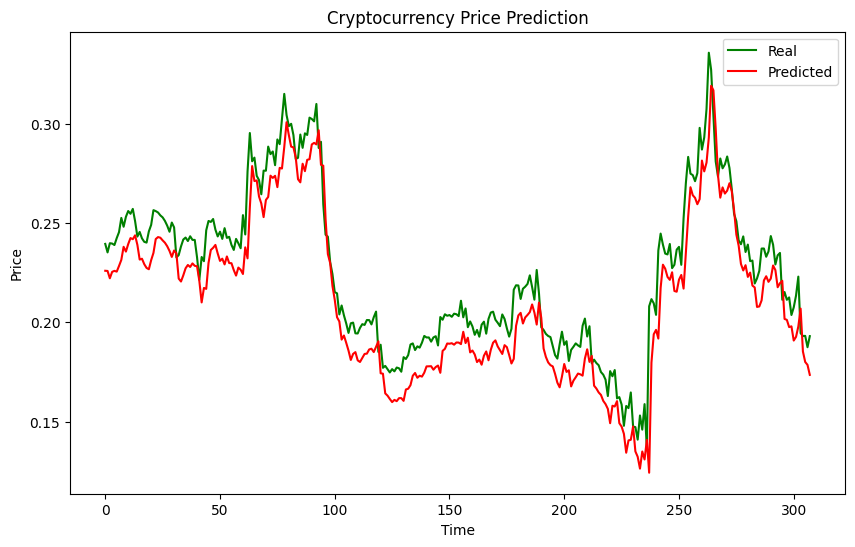

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(real, label="Real", color="green")
plt.plot(pred, label="Predicted", color="red")
plt.title("Cryptocurrency Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
